In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
import re

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.cluster import KMeans
import plotly.express as px

from utils.utils import *

# Loading Data

In [70]:
#GitHub TidyVerse data
user_reviews = pd.read_table('https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2020/2020-05-05/user_reviews.tsv')
critic = pd.read_table('https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2020/2020-05-05/critic.tsv')
items = pd.read_csv('https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2020/2020-05-05/items.csv')
tidy_villagers = pd.read_csv('https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2020/2020-05-05/villagers.csv')

#Local data
villagers = pd.read_csv("data/acnh_villager.csv", index_col=0)
compatibility_villagers = pd.read_csv("data/compatibility_villagers.csv", index_col=0)
compatibility_matrix = pd.read_csv("data/compatibility_matrix.csv", index_col=0)
tier_rank = pd.read_csv("data/acnh_villager_rank_data.csv")

***
# EDA (Exploratory Data Analysis)

## Villagers database

We will use hear the data collected from the API of Nookipedia, which is more completed than the data from the TidyVerse github repository.

In [3]:
villagers.set_index("name",inplace=True)
villagers

,gender,species,personality,sign,hobby,n_appearances,tier,rank
name,,,,,,,,
Raymond,Male,Cat,Smug,Libra,Nature,1,1,1
Marshal,Male,Squirrel,Smug,Libra,Music,4,1,2
Shino,Female,Deer,Peppy,Scorpio,Education,1,1,3
Sherb,Male,Goat,Lazy,Capricorn,Nature,1,1,4
Sasha,Male,Rabbit,Lazy,Taurus,Fashion,1,1,5
...,...,...,...,...,...,...,...,...
Rocco,Male,Hippo,Cranky,Leo,Education,9,6,409
Bettina,Female,Mouse,Normal,Gemini,Education,4,6,410
Boris,Male,Pig,Cranky,Scorpio,Nature,5,6,411


<AxesSubplot:>

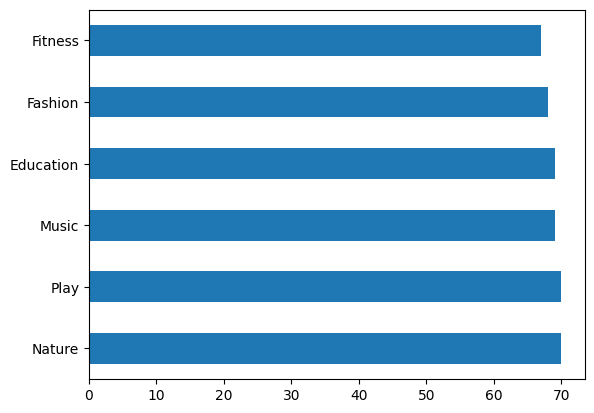

In [358]:
villagers.hobby.value_counts().plot(kind="barh")

<AxesSubplot:>

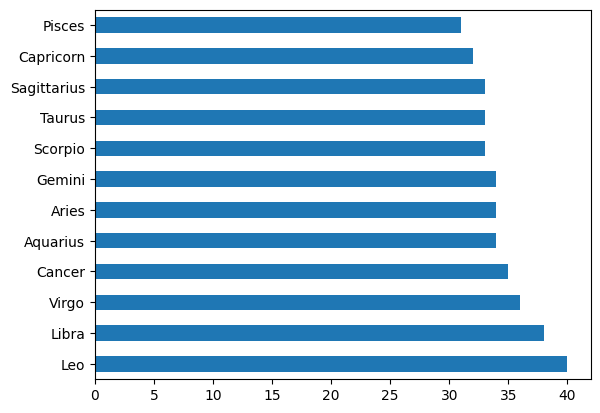

In [357]:
villagers.sign.value_counts().plot(kind="barh")

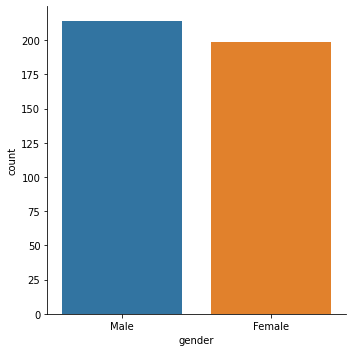

In [4]:
sns.catplot(x="gender", kind="count", data=villagers)

In [363]:
villagers["species"].describe()

count     413
unique     35
top       Cat
freq       23
Name: species, dtype: object

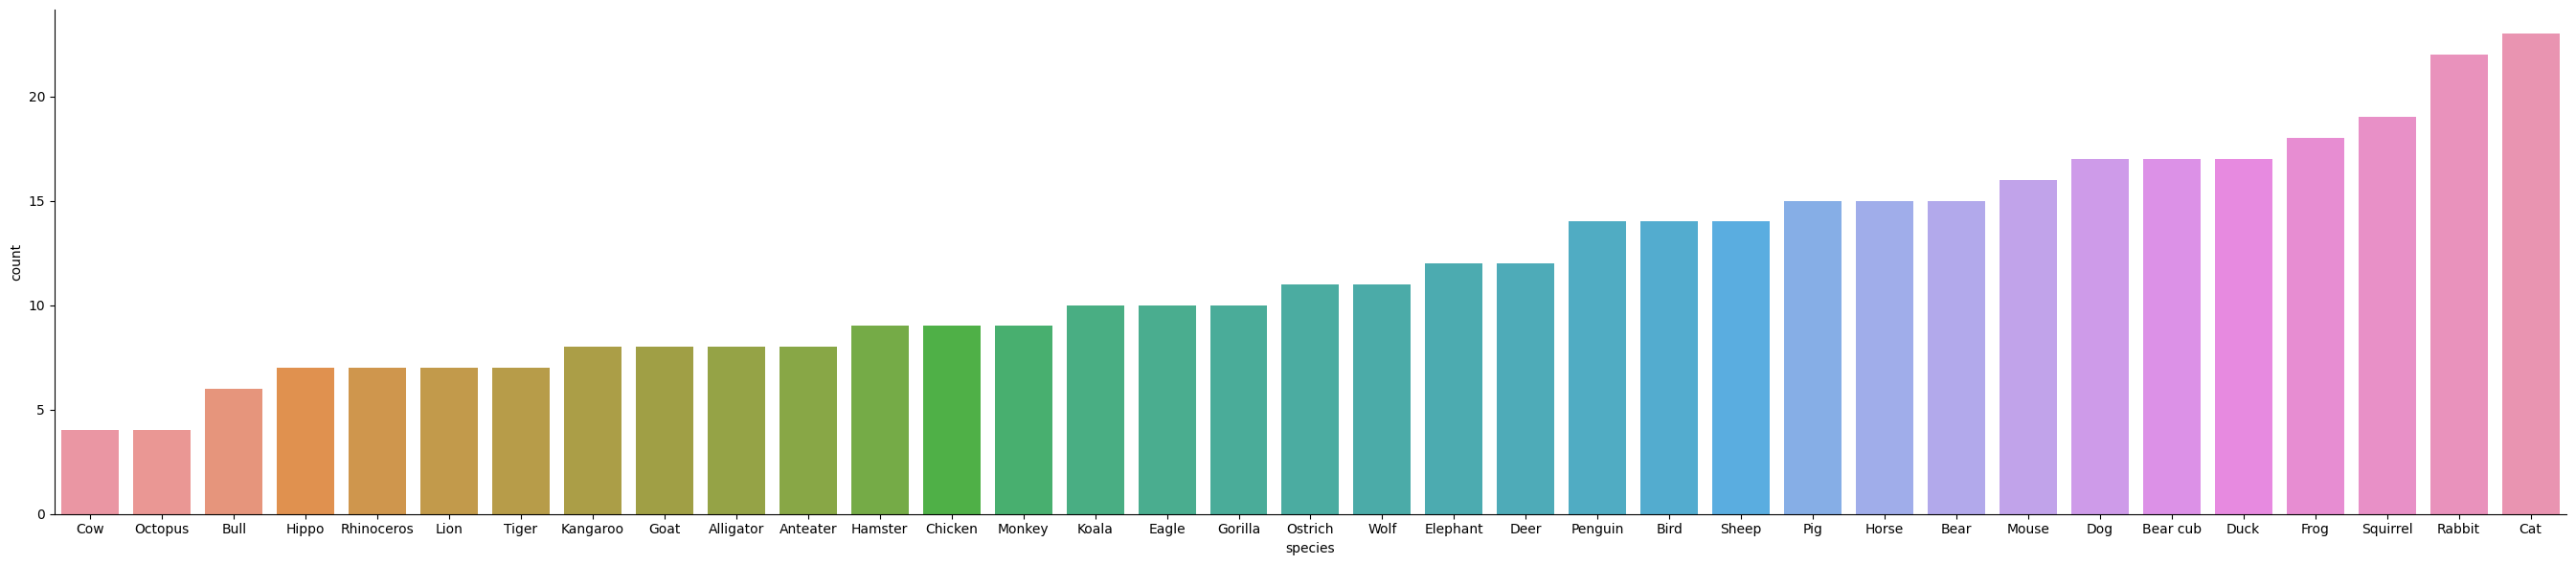

In [359]:
sns.catplot(x="species", kind="count", data=villagers, order=villagers["species"].value_counts().sort_values().index, height=6, aspect=4.5)

In [364]:
villagers["personality"].describe()

count      413
unique       8
top       Lazy
freq        63
Name: personality, dtype: object

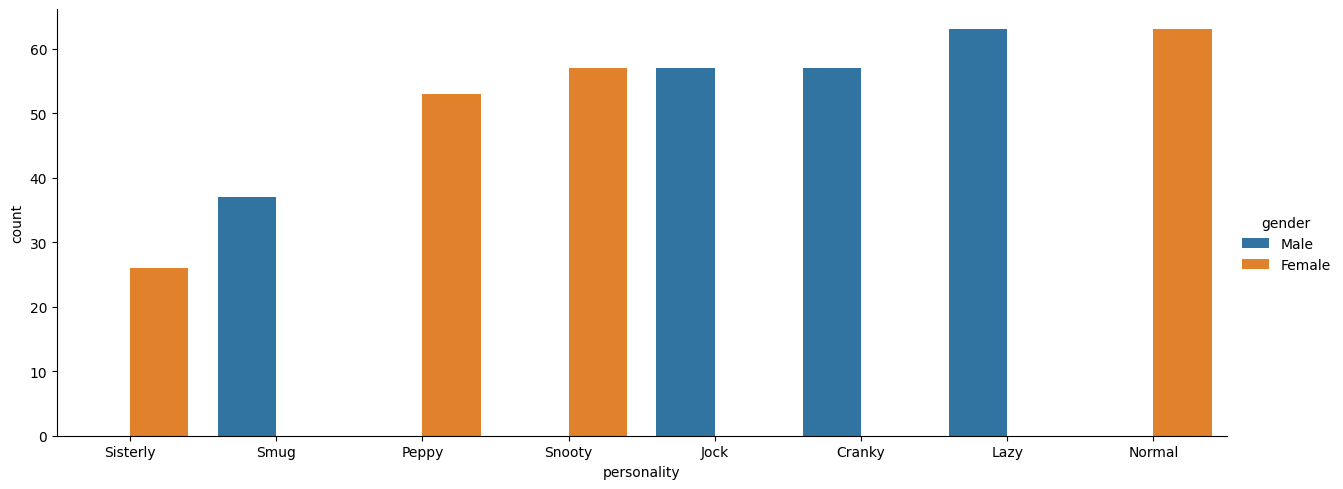

In [6]:
sns.catplot(x="personality", kind="count", hue="gender", order=villagers["personality"].value_counts().sort_values().index ,data=villagers,  aspect=2.5)

In [7]:
villagers.info()

<class 'pandas.core.frame.DataFrame'>
Index: 413 entries, Raymond to Velma
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   gender         413 non-null    object
 1   species        413 non-null    object
 2   personality    413 non-null    object
 3   sign           413 non-null    object
 4   hobby          413 non-null    object
 5   n_appearances  413 non-null    int64 
 6   tier           413 non-null    int64 
 7   rank           413 non-null    int64 
dtypes: int64(3), object(5)
memory usage: 45.2+ KB


## Villagers popularity analysis

### Gender analysis

In [379]:
villagers

,gender,species,personality,sign,hobby,n_appearances,tier,rank,labels
name,,,,,,,,,
Raymond,Male,Cat,Smug,Libra,Nature,1,1,1,5
Marshal,Male,Squirrel,Smug,Libra,Music,4,1,2,5
Shino,Female,Deer,Peppy,Scorpio,Education,1,1,3,2
Sherb,Male,Goat,Lazy,Capricorn,Nature,1,1,4,0
Sasha,Male,Rabbit,Lazy,Taurus,Fashion,1,1,5,0
...,...,...,...,...,...,...,...,...,...
Rocco,Male,Hippo,Cranky,Leo,Education,9,6,409,3
Bettina,Female,Mouse,Normal,Gemini,Education,4,6,410,4
Boris,Male,Pig,Cranky,Scorpio,Nature,5,6,411,3


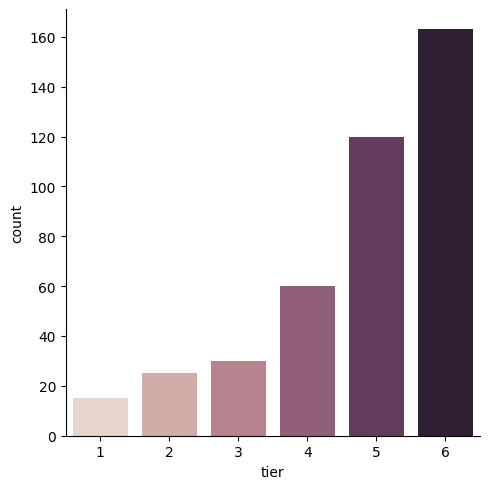

In [378]:
sns.catplot(x="tier", kind="count", palette="ch:.15", data=villagers)

<AxesSubplot:xlabel='gender', ylabel='rank'>

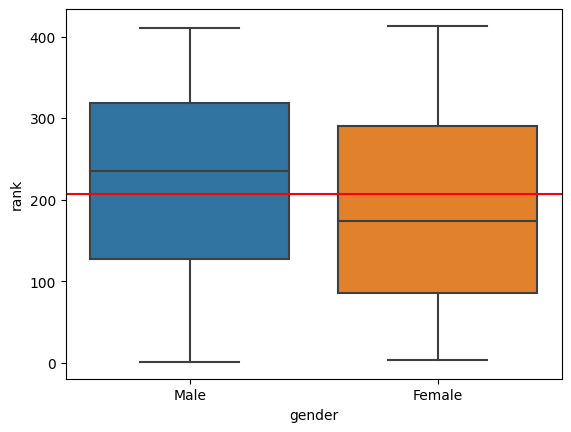

In [9]:
plt.axhline(villagers["rank"].mean(), color='r')
sns.boxplot(x="gender", y="rank", data=villagers)

### Species analysis

In [439]:
villagers[villagers["species"] == "Octopus"].species.describe()

count           4
unique          1
top       Octopus
freq            4
Name: species, dtype: object

In [10]:
#Visualizing the popularity amongst species 
species_rank = villagers.pivot_table(values="rank", index=["species"], 
                                aggfunc={'species': np.count_nonzero,
                                            'rank': np.mean
                                        }).sort_values("rank")
species_rank.columns=["mean_rank","n"]

In [486]:
species_rank = species_rank["mean_rank"]/species_rank["n"]
species_rank.sort_values(inplace=True)

<AxesSubplot:xlabel='species'>

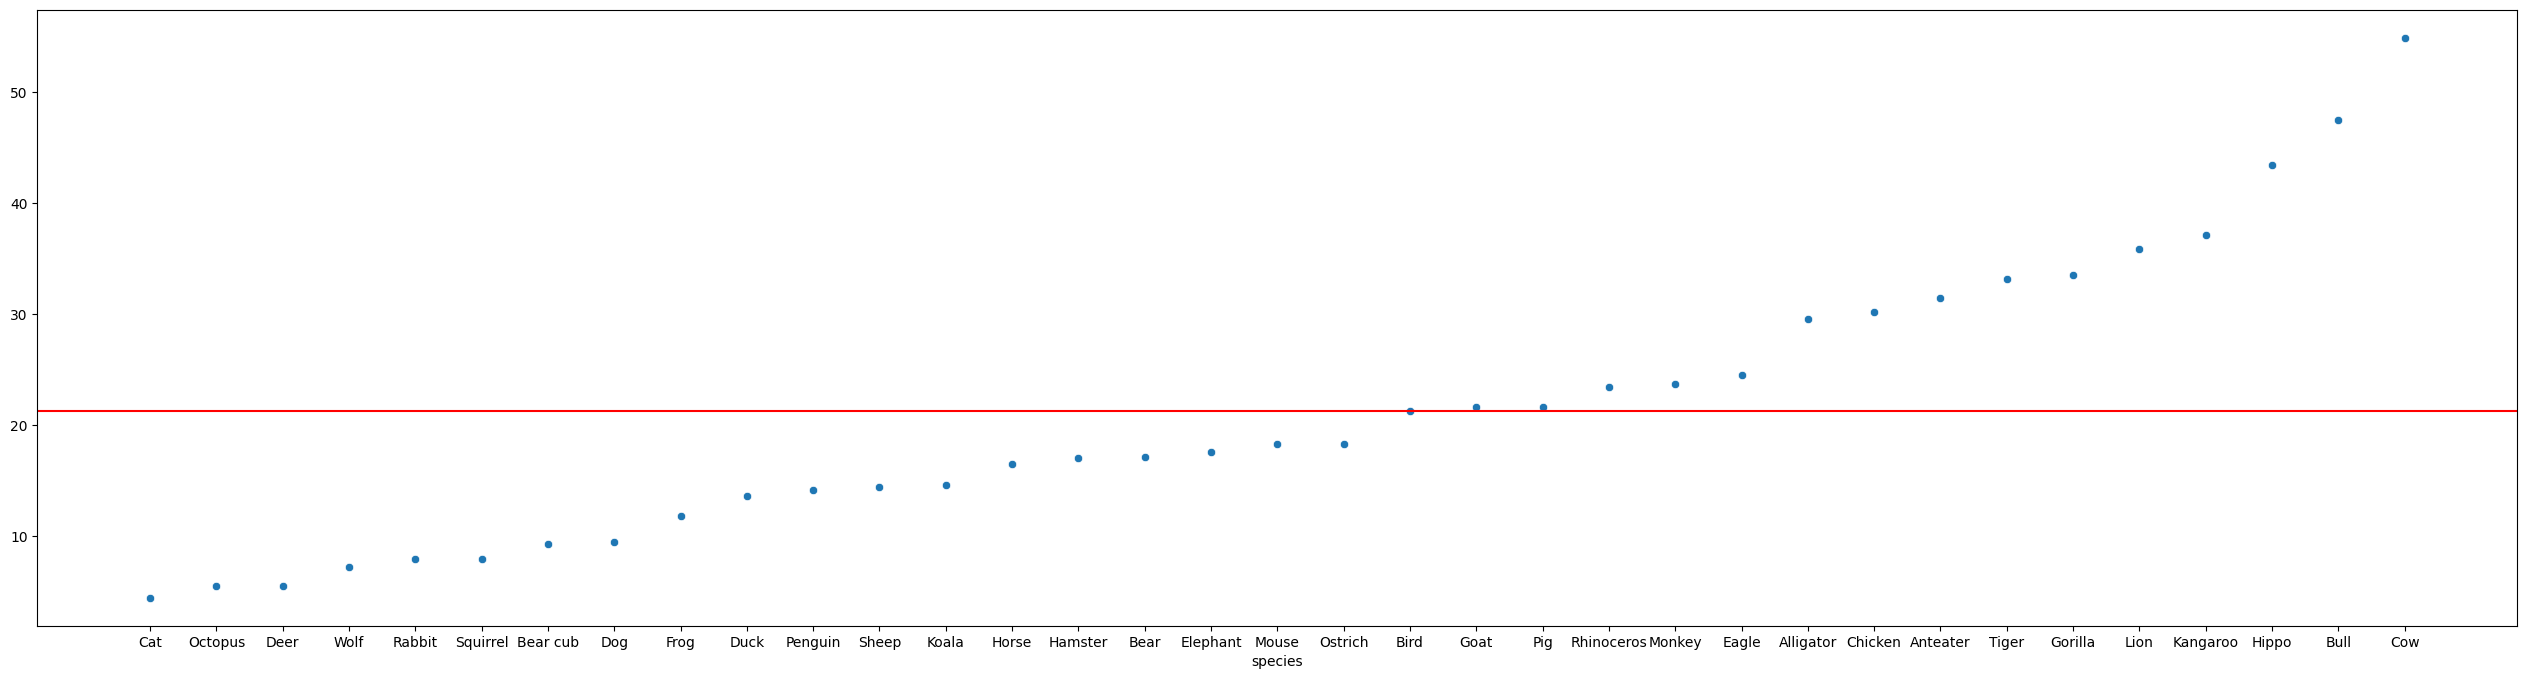

In [435]:
plt.figure(figsize=(32,8))
plt.axhline(rank.mean(), color='r')
sns.scatterplot(x=rank.index, y=rank, sizes=(20, 200))

<AxesSubplot:xlabel='species', ylabel='mean_rank'>

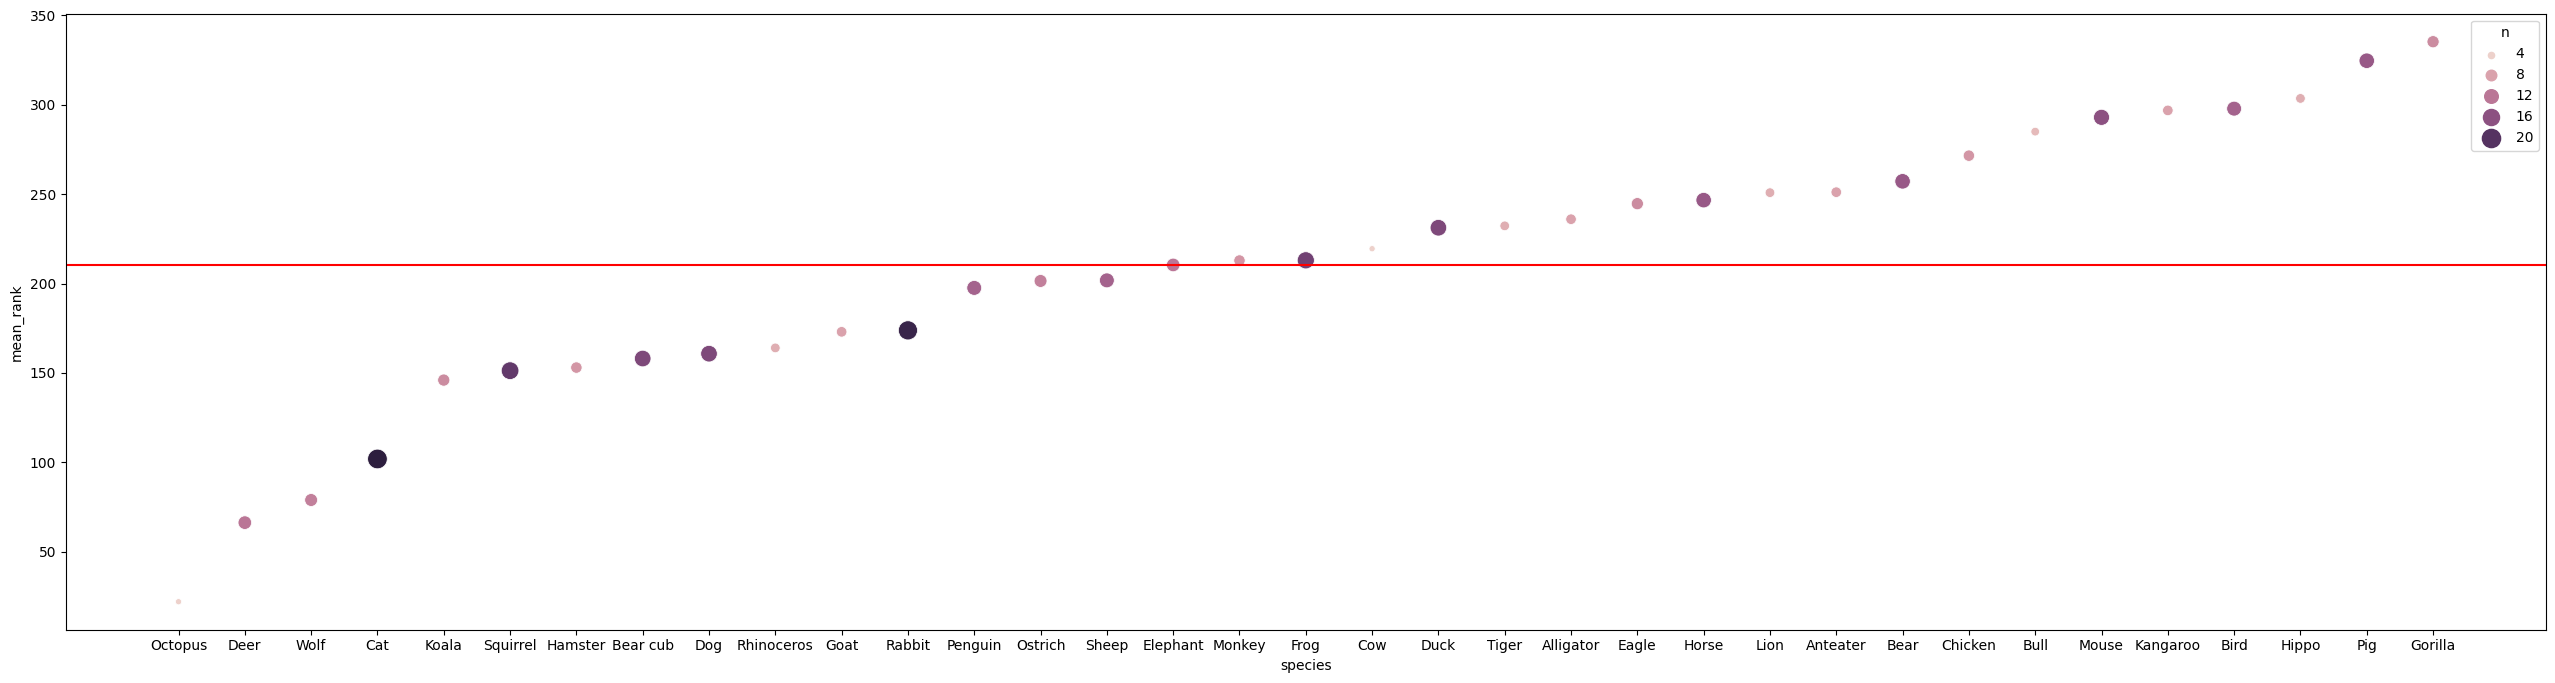

In [427]:
plt.figure(figsize=(32,8))
plt.axhline(species_rank["mean_rank"].mean(), color='r')
sns.scatterplot(x=species_rank.index, y="mean_rank", hue="n", size="n", sizes=(20, 200), data=species_rank)

In [489]:
fig = px.scatter(species_rank, size=species_rank)
fig.show()

### Personality analysis

In [12]:
#Constructing a dataframe counting the number of different personalities for each species
df = villagers[["personality","species"]]
species_personality = df.pivot_table(index="species", columns="personality", aggfunc=np.count_nonzero)
species_personality.fillna(0, inplace=True)
species_personality = species_personality.astype("int64")

<AxesSubplot:xlabel='species'>

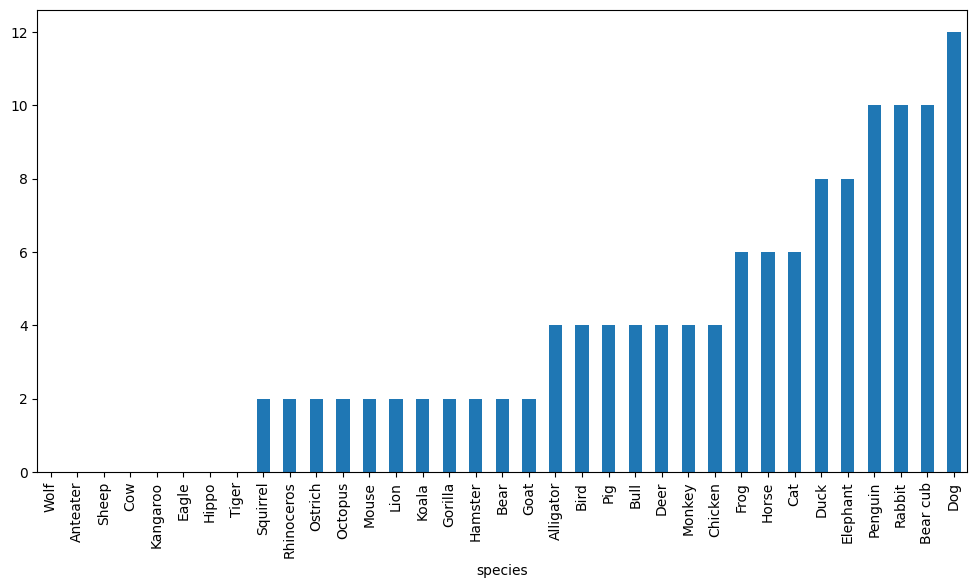

In [13]:
plt.figure(figsize=(12,6))
species_personality["Lazy"].sort_values().plot(kind="bar")

In [483]:
#Visualizing the relationship between personality and popularity 
personality_rank = villagers.pivot_table(index=["personality"], 
                                aggfunc={'personality': np.count_nonzero,
                                            'rank': np.mean
                                        }).sort_values("rank")
personality_rank.columns=["n","mean_rank"]

In [484]:
personality_rank = personality_rank["mean_rank"]/personality_rank["n"]
personality_rank.sort_values(inplace=True)

In [485]:
fig = px.scatter(personality_rank, size=personality_rank, color=personality_rank.index, width=500)
fig.show()

<AxesSubplot:xlabel='personality', ylabel='mean_rank'>

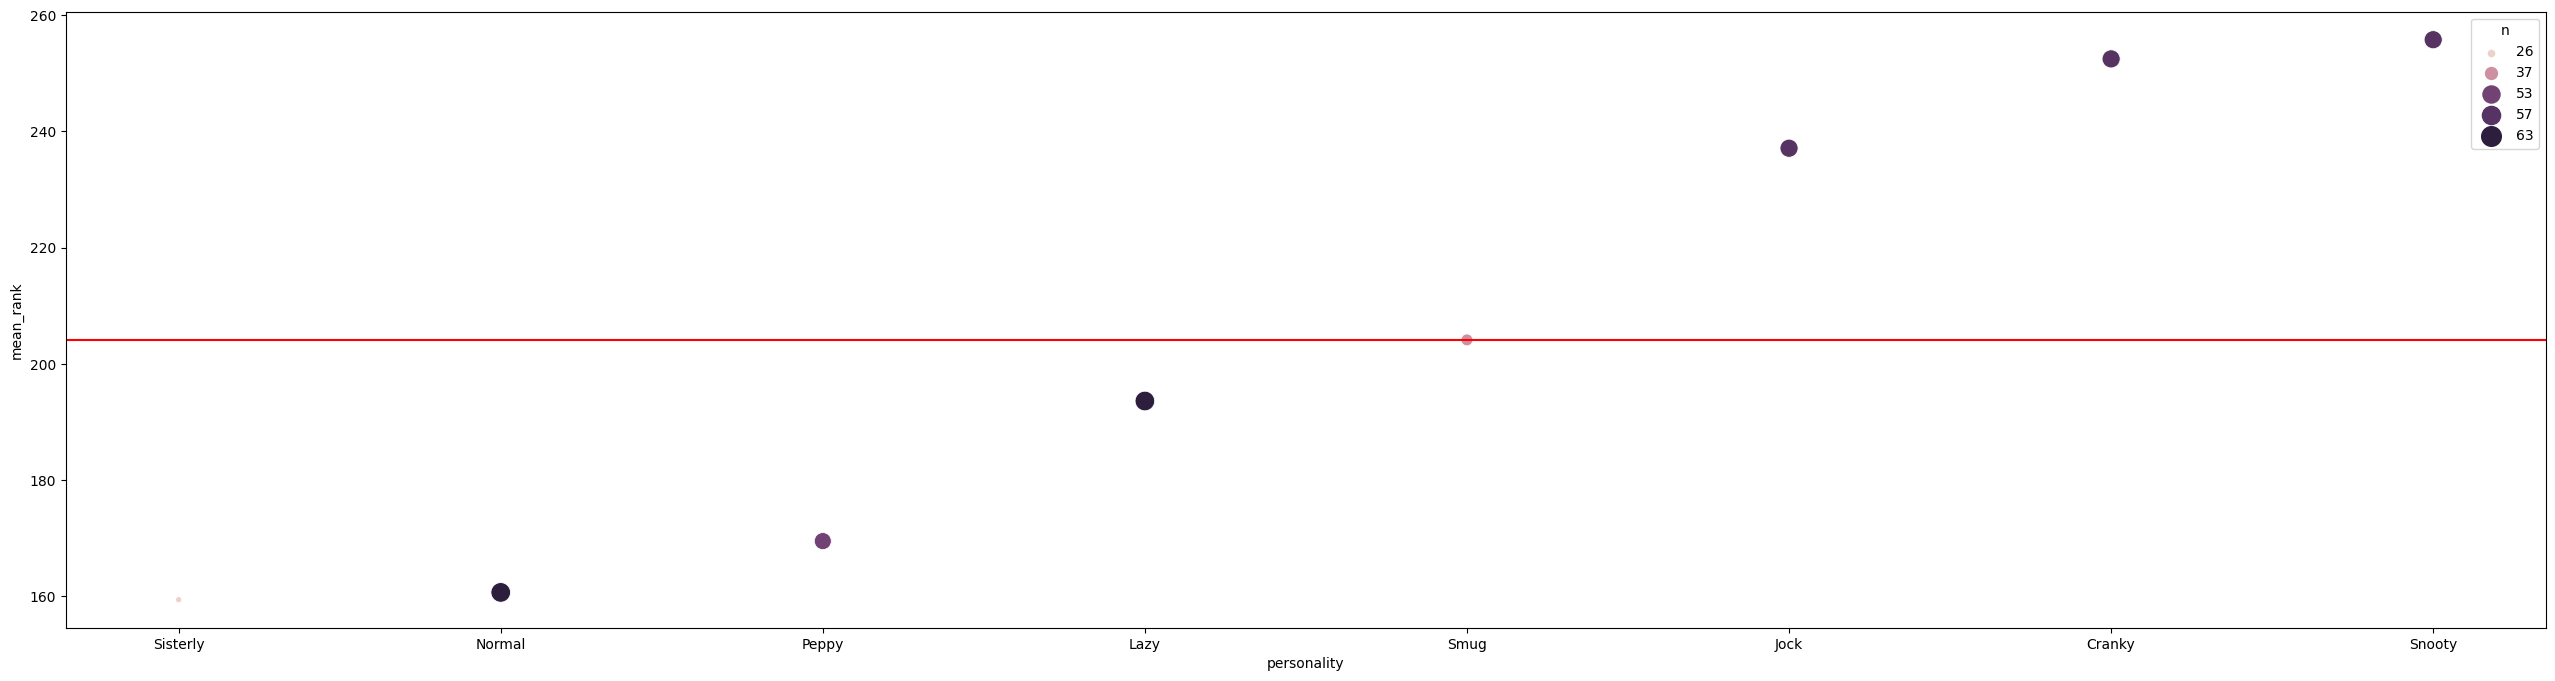

In [446]:
plt.figure(figsize=(32,8))
plt.axhline(personality_rank["mean_rank"].mean(), color='r')
sns.scatterplot(x=personality_rank.index, y="mean_rank", hue="n", size="n", sizes=(20, 200), data=personality_rank)

## Items dataset

In [16]:
items

,num_id,id,name,category,orderable,sell_value,sell_currency,buy_value,buy_currency,sources,customizable,recipe,recipe_id,games_id,id_full,image_url
0,12,3d-glasses,3D Glasses,Accessories,NaN,122.0,bells,490.0,bells,NaN,NaN,NaN,NaN,nh,item-3d-glasses,https://villagerdb.com/images/items/full/3d-gl...
1,14,a-tee,A Tee,Tops,NaN,140.0,bells,560.0,bells,NaN,NaN,NaN,NaN,nh,item-a-tee,https://villagerdb.com/images/items/full/a-tee...
2,17,abstract-wall,Abstract Wall,Wallpaper,True,390.0,bells,1560.0,bells,Nook's Cranny,NaN,NaN,NaN,nh,NaN,NaN
3,19,academy-uniform,Academy Uniform,Dresses,NaN,520.0,bells,2080.0,bells,NaN,NaN,NaN,NaN,nh,item-academy-uniform,https://villagerdb.com/images/items/full/acade...
4,20,acanthostega,Acanthostega,Fossils,False,2000.0,bells,NaN,NaN,Underground (dig spot),NaN,NaN,NaN,nh,item-acanthostega,https://villagerdb.com/images/items/thumb/acan...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4560,7425,zigzag-shirt,Zigzag Shirt,Tops,True,240.0,bells,960.0,bells,Nook Shopping,NaN,NaN,NaN,nh,item-zigzag-shirt,https://villagerdb.com/images/items/full/zigza...
4561,7428,zippers-poster,Zipper's Poster,Photos,NaN,250.0,bells,1000.0,bells,NaN,NaN,NaN,NaN,nh,NaN,NaN
4562,7441,zori,Zori,Shoes,NaN,1075.0,bells,4300.0,bells,NaN,NaN,NaN,NaN,nh,item-zori,https://villagerdb.com/images/items/full/zori....
4563,7442,zuckers-photo,Zucker's Photo,Photos,NaN,10.0,bells,40.0,bells,NaN,NaN,NaN,NaN,nh,NaN,NaN


In [17]:
#Droping useless features
items.drop(columns=["id", "num_id", "id_full","image_url"], inplace=True)

In [18]:
list(items["category"].value_counts().sort_values(ascending=False).index)

['Furniture',
 'Photos',
 'Flooring',
 'Tops',
 'Wallpaper',
 'Dresses',
 'Hats',
 'Bottoms',
 'Accessories',
 'Flowers',
 'Fish',
 'Music',
 'Shoes',
 'Usables',
 'Bugs',
 'Fossils',
 'Tools',
 'Umbrellas',
 'Socks',
 'Fruit',
 'Seashells']

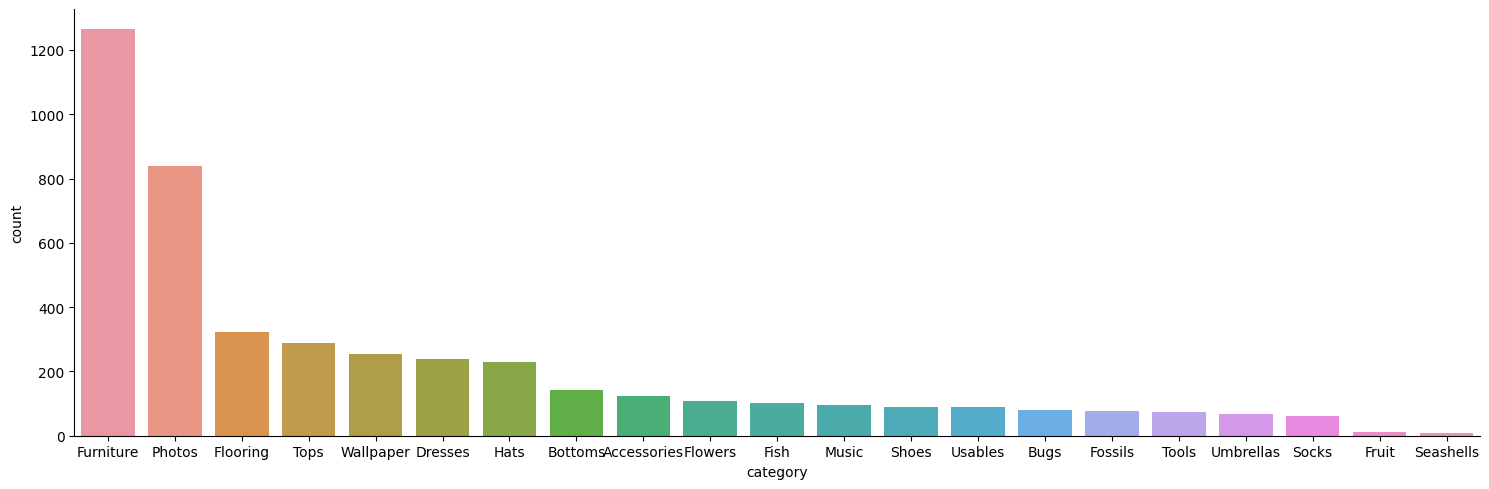

In [19]:
sns.catplot(kind="count", x="category", data=items, order=list(items["category"].value_counts().sort_values(ascending=False).index),
            orient="h", aspect=3.0)

In [20]:
#Check for missing values and some overall info about the data set
items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4565 entries, 0 to 4564
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   name           4565 non-null   object 
 1   category       4565 non-null   object 
 2   orderable      1790 non-null   object 
 3   sell_value     4529 non-null   float64
 4   sell_currency  4529 non-null   object 
 5   buy_value      3551 non-null   float64
 6   buy_currency   3551 non-null   object 
 7   sources        902 non-null    object 
 8   customizable   575 non-null    object 
 9   recipe         588 non-null    float64
 10  recipe_id      588 non-null    object 
 11  games_id       4565 non-null   object 
dtypes: float64(3), object(9)
memory usage: 428.1+ KB


In [21]:
#Summary of how many missing values are contained within the dataframe
items.isna().sum()

name                0
category            0
orderable        2775
sell_value         36
sell_currency      36
buy_value        1014
buy_currency     1014
sources          3663
customizable     3990
recipe           3977
recipe_id        3977
games_id            0
dtype: int64

<AxesSubplot:>

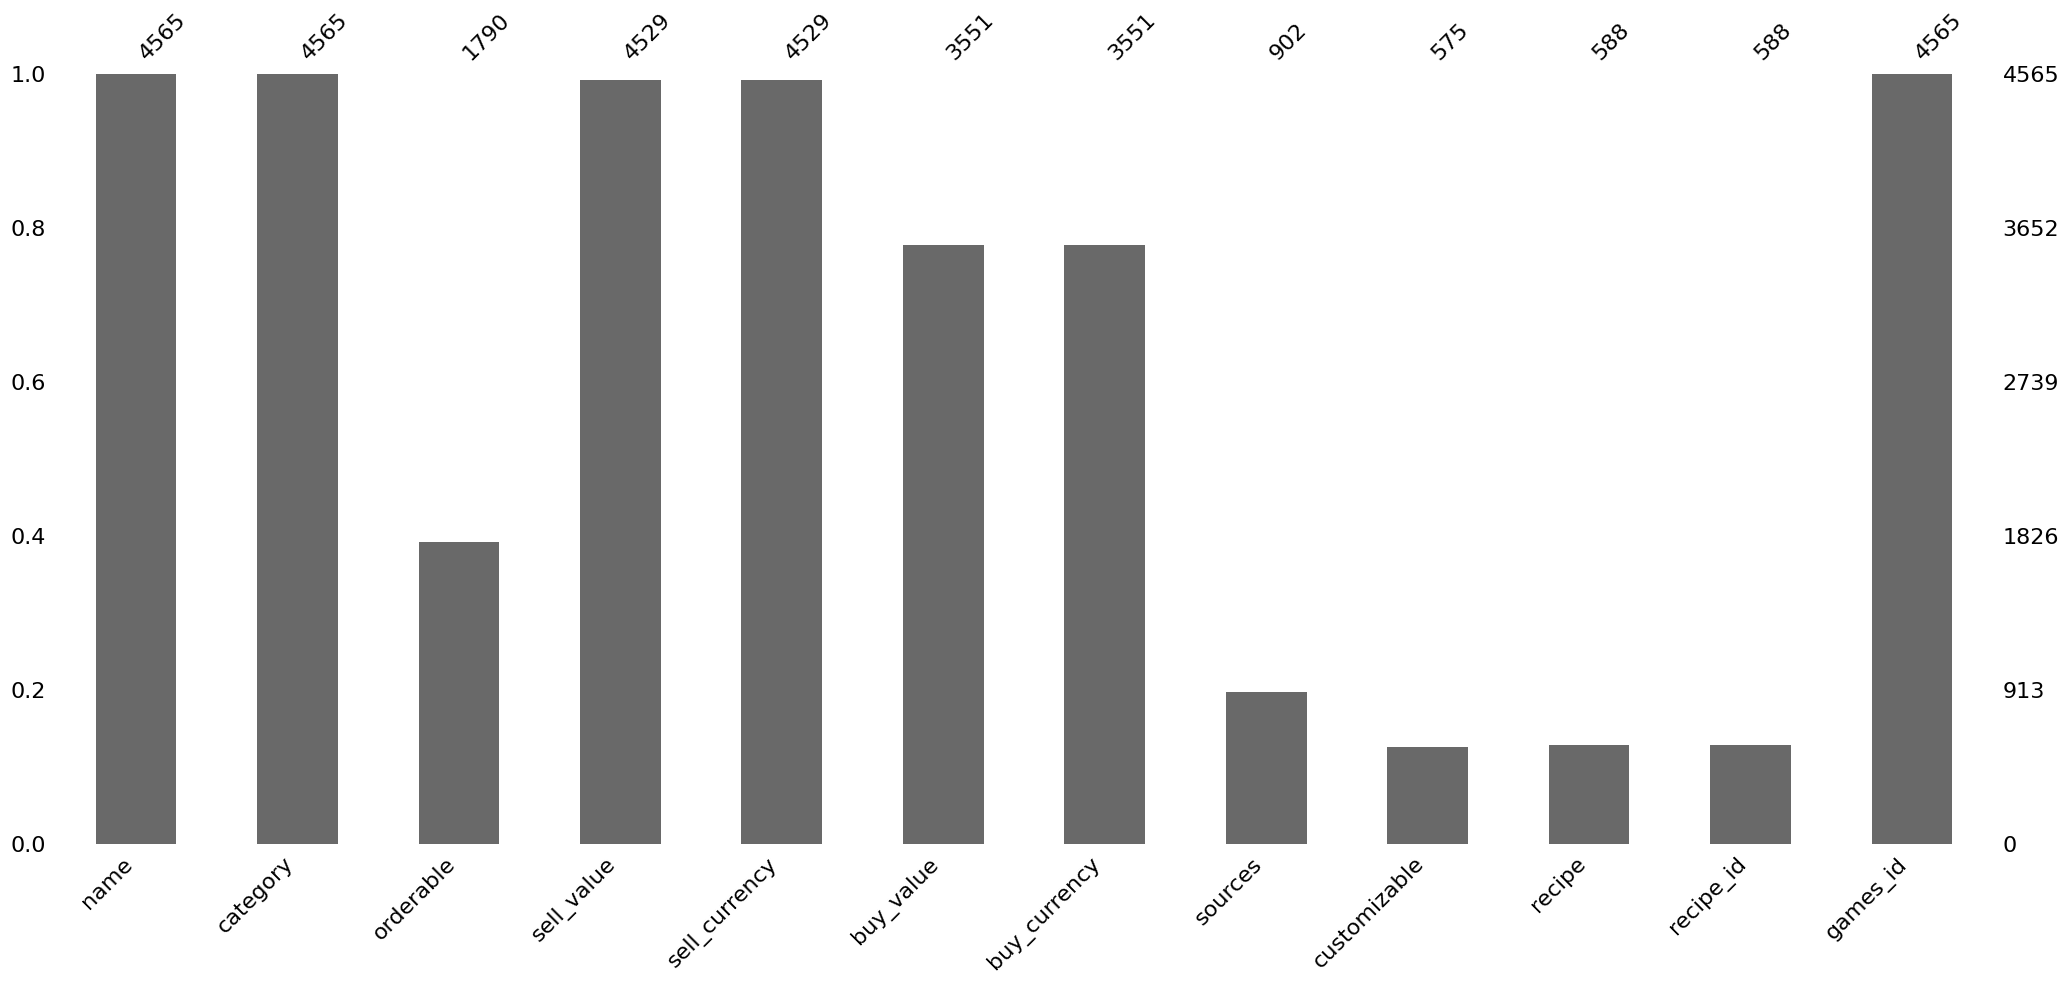

In [22]:
#Visualizing missing values
msno.bar(items)

<AxesSubplot:>

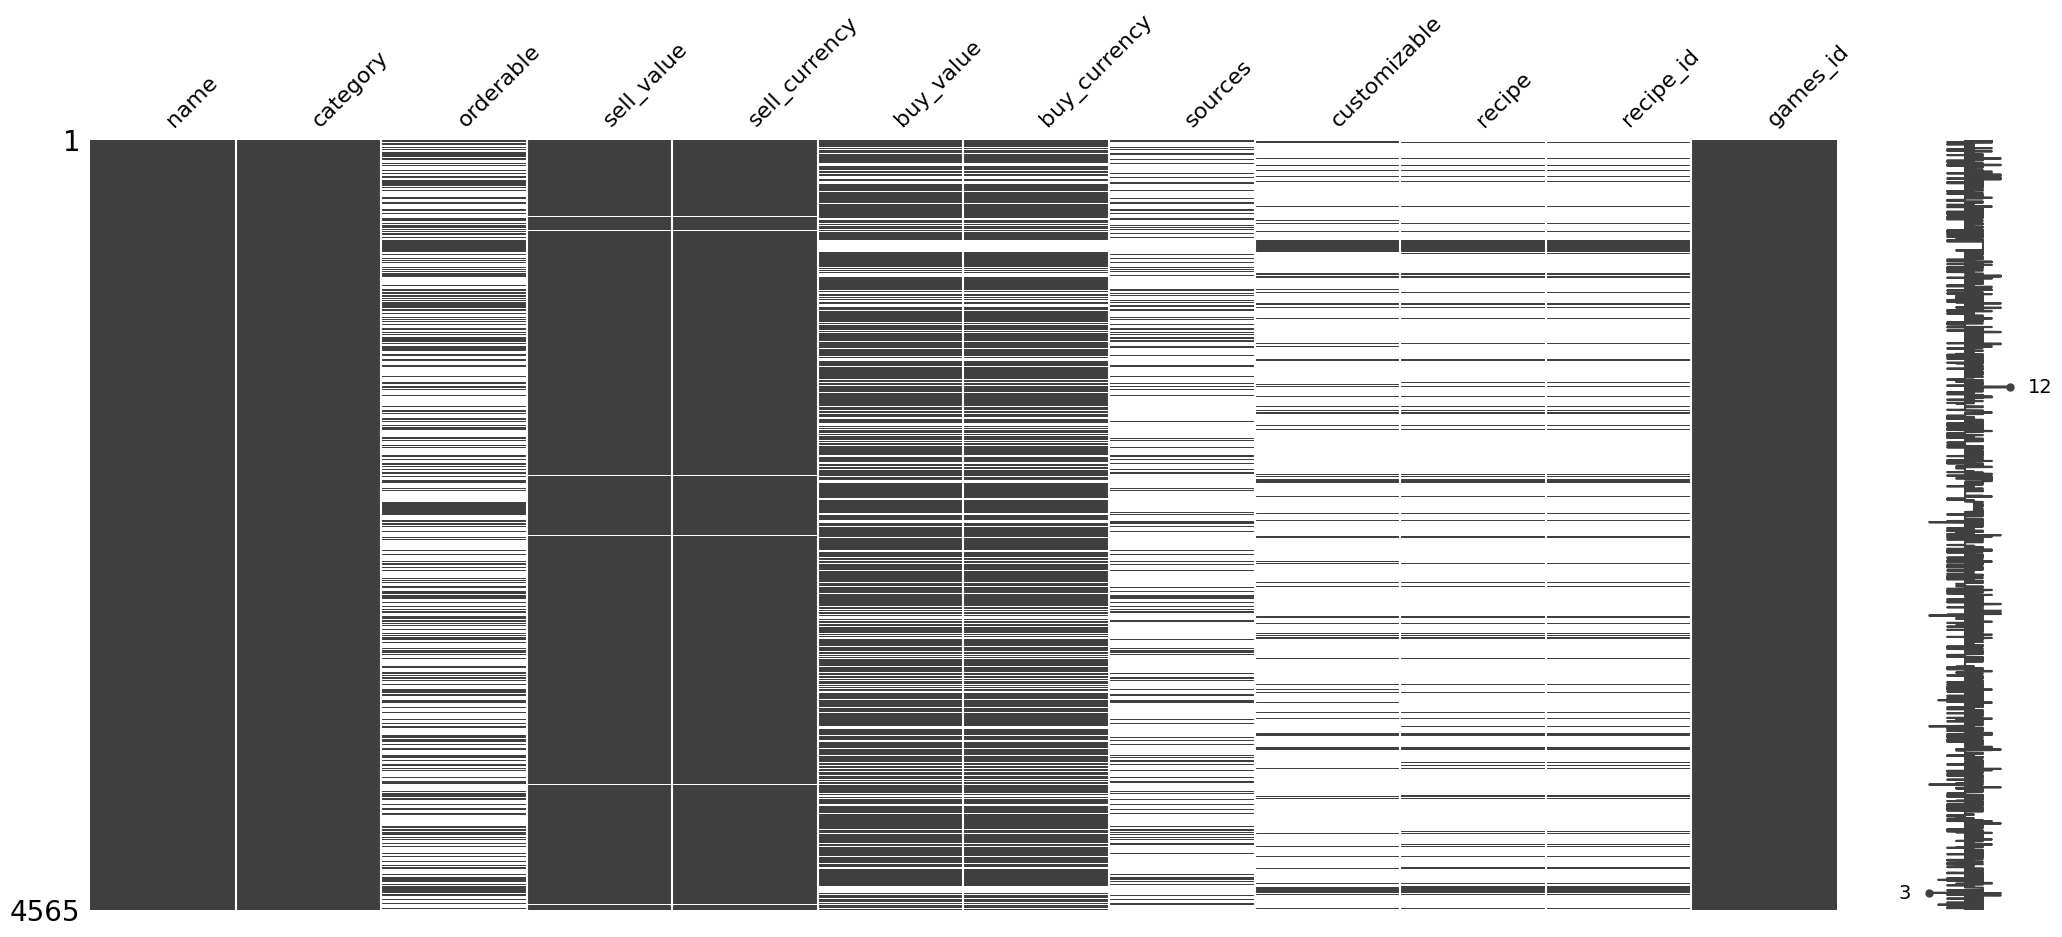

In [23]:
#Visualizing where the missing values are located 
msno.matrix(items)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='sell_value', ylabel='Density'>

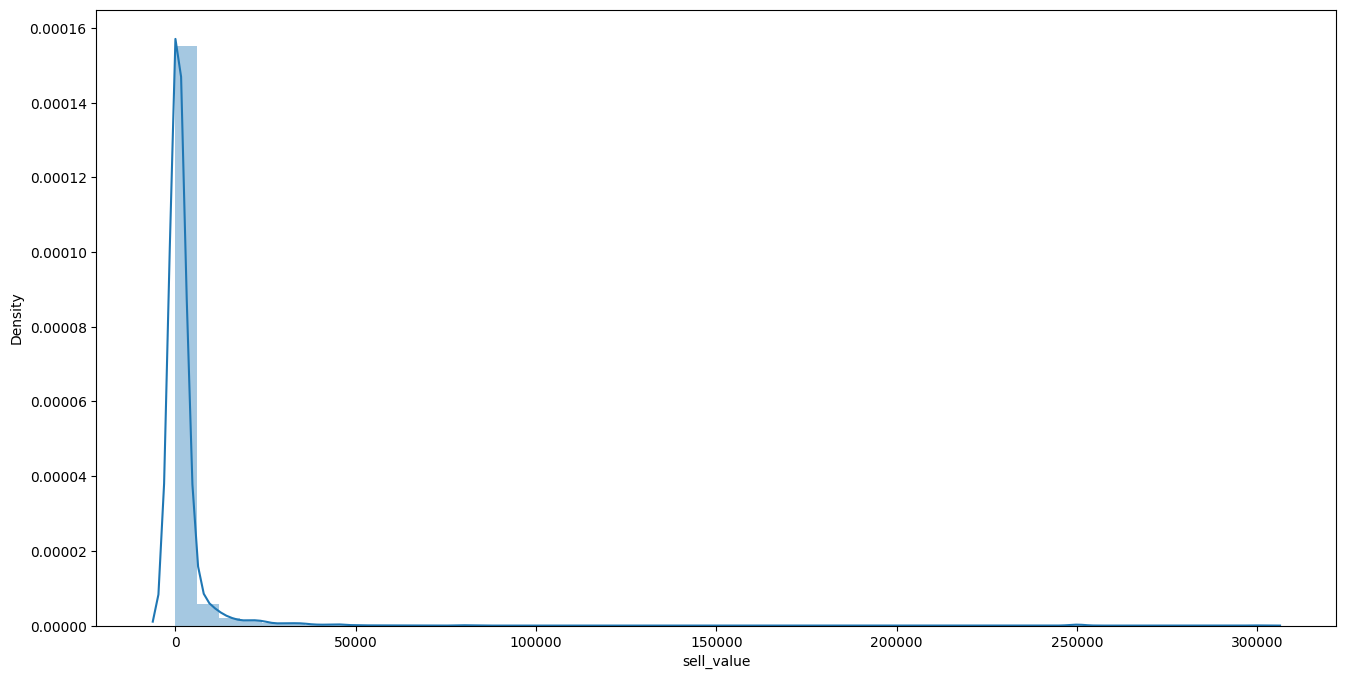

In [24]:
#Trying to vizualise the sell_value distribution, however due to some high sell_values the distribution is hard to determine
plt.figure(figsize=(16,8))
sns.distplot(a=items["sell_value"])

In [25]:
items["sell_value"].describe()

count      4529.000000
mean       2261.378229
std       11313.225932
min           5.000000
25%         240.000000
50%         390.000000
75%        1000.000000
max      300000.000000
Name: sell_value, dtype: float64

<AxesSubplot:xlabel='sell_value'>

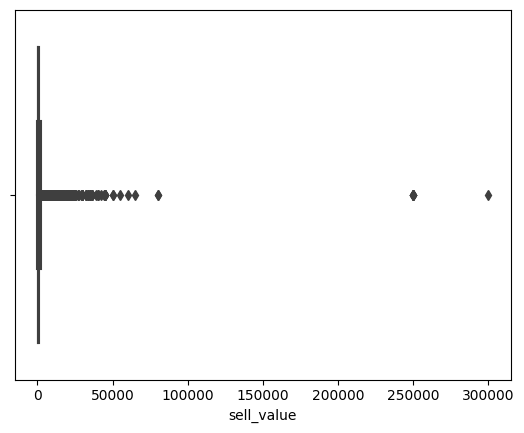

In [26]:
sns.boxplot(x=items["sell_value"])

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='sell_value', ylabel='Density'>

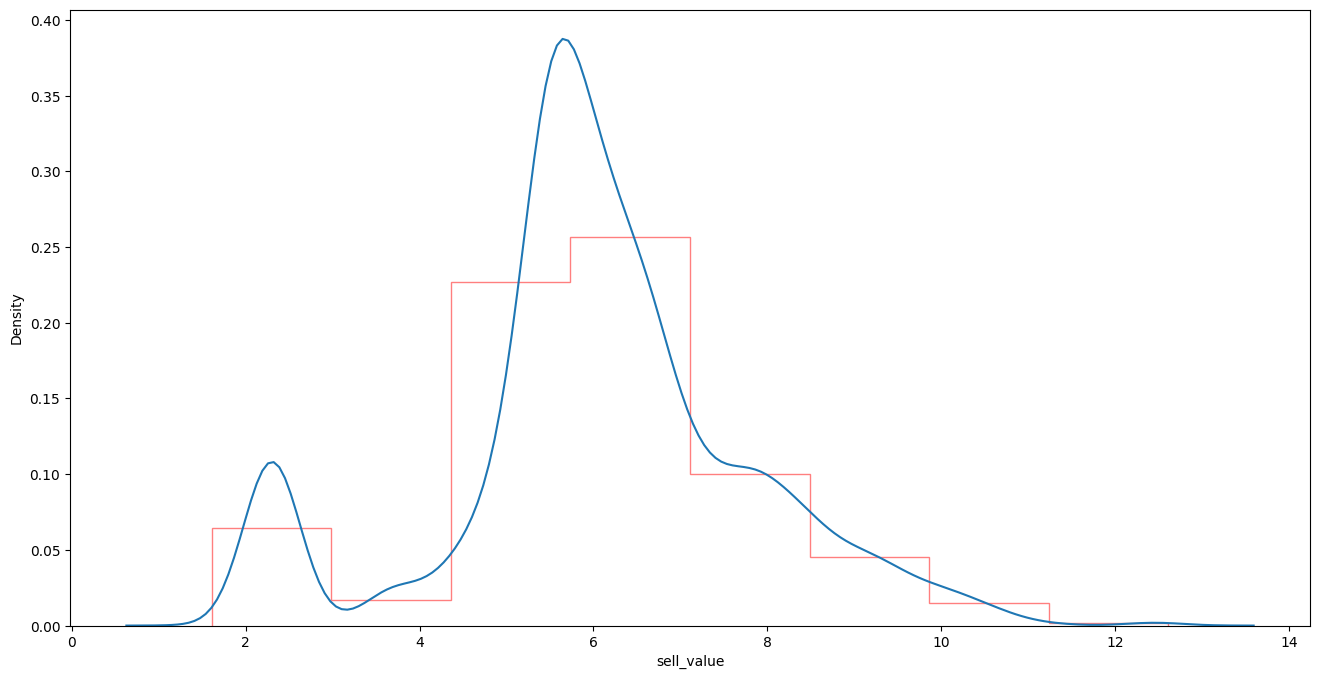

In [27]:
#To overcome the extreme values impact on the distribution vizualization, let's transform our data with the log function
plt.figure(figsize=(16,8))
sns.distplot(a=np.log(items["sell_value"]), bins=8,
            hist_kws={"histtype": "step", "linewidth": 1,
                    "alpha": 0.5, "color": "r"})

<AxesSubplot:xlabel='sell_value', ylabel='buy_value'>

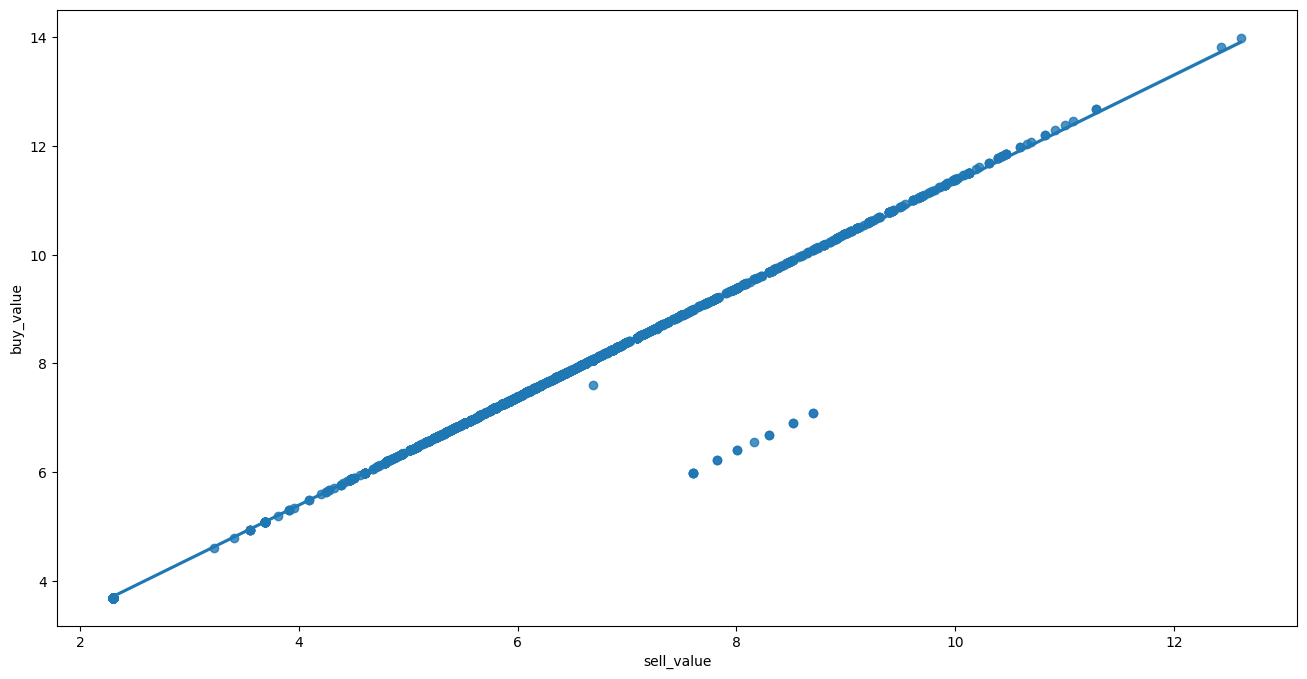

In [28]:
#The relationship between the sell and the buy value is a nearly perfect linear relationship
plt.figure(figsize=(16,8))
sns.regplot(x=np.log(items["sell_value"]), y=np.log(items["buy_value"]))

## Compatibility analysis

Goal: from the compatibily matrix, extract conclusion from the initial dataset (can we find clusters of personality? species? gender?)

In [29]:
matrix = compatibility_matrix.replace([0, 2], [-1, 3])

In [30]:
similarity = compatibility_matrix.copy()
dissimilarity = 2 - similarity

In [540]:
similarity

,Ace,Admiral,Agent S,Agnes,Al,Alfonso,Alice,Alli,Amelia,Anabelle,...,Weber,Wendy,Whitney,Willow,Winnie,Wolfgang,Yuka,Zell,Zoe,Zucker
name,,,,,,,,,,,,,,,,,,,,,
Ace,2,1,1,1,1,1,2,0,0,2,...,0,2,1,1,2,1,0,1,1,0
Admiral,1,2,1,1,2,2,1,2,2,1,...,1,1,1,2,1,2,2,1,1,1
Agent S,1,1,2,1,1,1,0,2,2,2,...,2,2,1,1,2,0,2,1,1,2
Agnes,1,1,1,2,1,1,1,1,1,1,...,2,1,1,1,1,1,1,0,1,2
Al,1,2,1,1,2,2,1,1,1,2,...,2,1,1,1,2,1,1,2,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Wolfgang,1,2,0,1,1,1,2,1,1,1,...,1,2,2,2,1,2,2,1,1,1
Yuka,0,2,2,1,1,1,2,1,1,1,...,1,1,1,1,1,2,2,1,2,1
Zell,1,1,1,0,2,1,2,1,1,1,...,1,1,1,1,2,1,1,2,2,1


We'll try to compute the cosine similarity:

In [31]:
from sklearn.metrics.pairwise import cosine_similarity

cosine = pd.DataFrame(cosine_similarity(compatibility_matrix, Y=None, dense_output=True), columns=compatibility_matrix.index, index= compatibility_matrix.index)
dissimilarity_cosine = 1 - cosine
np.fill_diagonal(dissimilarity_cosine.values, 0)

From the new matrix, we can try a clustering

In [608]:
from sklearn.cluster import AgglomerativeClustering

model = AgglomerativeClustering(affinity="precomputed", linkage="average", n_clusters=4)
cls = model.fit(dissimilarity_cosine)
clusters = pd.Series(cls.labels_, name="cluster", index=dissimilarity.index)

16.98386791992931

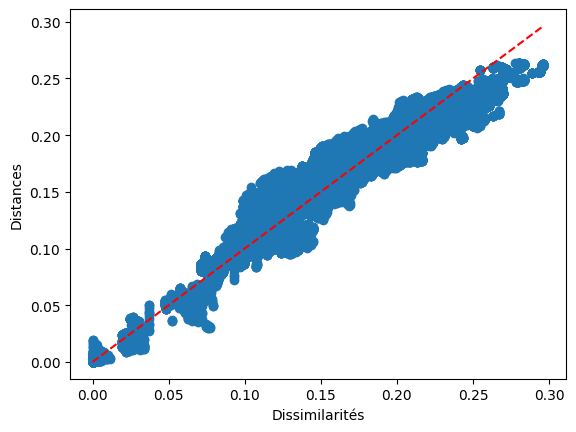

In [595]:
from sklearn.manifold import MDS
aftd = MDS(n_components=5, dissimilarity='precomputed')
compatibility = aftd.fit_transform(dissimilarity_cosine)
plot_Shepard(aftd)
aftd.stress_

In [619]:
# px.scatter_3d(x=dist[:,0], y=dist[:,1], z=dist[:,2], color=labels)
px.scatter(x=compatibility[:,0], y=compatibility[:,1], color=clusters)
px.scatter_3d(x=compatibility[:,0], y=compatibility[:,1], z=compatibility[:,2], color=clusters)

In [610]:
df = px.data.iris()
features = [0,1,2,3,4]

fig = px.scatter_matrix(
    compatibility,
    dimensions=features,
    color=clusters
)
fig.update_traces(diagonal_visible=False)
fig.show()

In [614]:
# villagers.drop(["labels", "cluster"], axis=1, inplace=True)

In [615]:
villagers = villagers.join(clusters)

In [622]:
for i in range(4):
    print(villagers[villagers["cluster"] == i].personality.value_counts())

Normal    63
Cranky    57
Name: personality, dtype: int64
Jock     57
Peppy    53
Name: personality, dtype: int64
Lazy        63
Sisterly    26
Name: personality, dtype: int64
Snooty    57
Smug      37
Name: personality, dtype: int64


**Conclusion** : difficile à interpréter


## Personality details

In [41]:
personality = pd.read_csv("data/personality.csv", index_col=0)

In [42]:
personality

,Friendly,Maturity,Caring,Self-centredness,Rudeness,Hot-temperedness,Arrogance,Stubborness
Personality,,,,,,,,
Snooty,0,1,0,1,1,1,1,0
Sisterly,1,0,1,1,1,0,0,0
Cranky,0,1,0,1,1,0,0,1
Jock,1,0,1,1,0,0,1,0
Smug,1,0,0,1,0,0,1,0
Peppy,1,0,1,0,0,1,0,0
Normal,1,0,1,1,0,0,0,0
Lazy,1,1,1,0,0,0,0,0


In [43]:
personality.index

Index(['Snooty', 'Sisterly', 'Cranky', 'Jock', 'Smug', 'Peppy', 'Normal',
       'Lazy'],
      dtype='object', name='Personality')

In [653]:
cls = PCA(n_components=3)
personality_acp = cls.fit_transform(personality)
cls.explained_variance_ratio_.sum()

0.8248717251417171

In [537]:
#https://plotly.com/python/pca-visualization/
loadings = cls.components_.T * np.sqrt(cls.explained_variance_)

fig = px.scatter(pcs, x=0, y=1, opacity=0.1, text=personality.index, labels= { '0': "Axis 0 of PCA", '1': "Axis 1 of PCA" }, width=600)

for i, feature in enumerate(personality.columns.values):
    fig.add_shape(
        type='line',
        x0=0, y0=0,
        x1=loadings[i, 0],
        y1=loadings[i, 1],
        opacity=0.3,
        line=dict(
            color="blue"
        )
    )
    fig.add_annotation(
        x=loadings[i, 0],
        y=loadings[i, 1],
        ax=0, ay=0,
        xanchor="center",
        yanchor="bottom",
        text=feature,
        opacity=0.8,
        font=dict(
            family="sans serif",
            size=10,
            color="Red"
        )
    )
fig.show()

***
# Clustering

The difficulty lay in the various categorical features contained in our dataset. One way to deal with those features are to use an encoder.

In [170]:
X = villagers.drop(["rank","tier", "n_appearances", "labels"], axis=1)

In [651]:
villagers

,gender,species,personality,sign,hobby,n_appearances,tier,rank,cluster
name,,,,,,,,,
Raymond,Male,Cat,Smug,Libra,Nature,1,1,1,3
Marshal,Male,Squirrel,Smug,Libra,Music,4,1,2,3
Shino,Female,Deer,Peppy,Scorpio,Education,1,1,3,1
Sherb,Male,Goat,Lazy,Capricorn,Nature,1,1,4,2
Sasha,Male,Rabbit,Lazy,Taurus,Fashion,1,1,5,2
...,...,...,...,...,...,...,...,...,...
Rocco,Male,Hippo,Cranky,Leo,Education,9,6,409,0
Bettina,Female,Mouse,Normal,Gemini,Education,4,6,410,0
Boris,Male,Pig,Cranky,Scorpio,Nature,5,6,411,0


We can use an **ordinal** encoder, which will wrongly assume an order relationship, or a **one hot** encoder, which is computationnally expensive.

In [172]:
onehot = OneHotEncoder(sparse=False)
X_onehot = onehot.fit_transform(X)

In [173]:
#Same as using pd.get_dummies
X_dummies = pd.get_dummies(X)

Now we can apply PCA on our dataset:

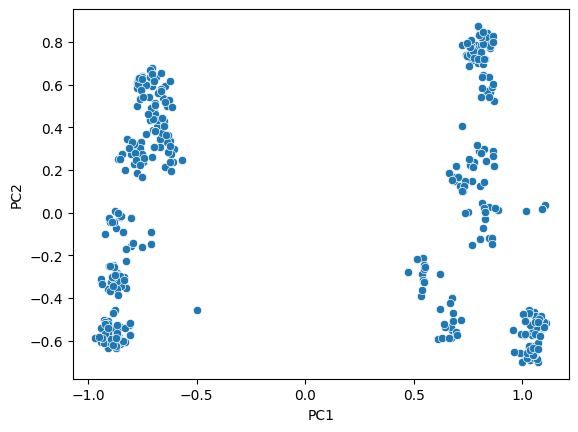

In [174]:
_, one_hot_pca = scatterplot_pca(data=pd.DataFrame(X_dummies))
X_onehot_pca = one_hot_pca.transform(X_dummies)

In [648]:
cls = PCA(n_components=25)
pcs = cls.fit_transform(X_dummies)
cls.explained_variance_ratio_.sum()

0.8094623913541555

We can then perform a clustering task:

In [180]:
cls = KMeans(n_clusters=6, init='k-means++')
cls.fit(X_onehot_pca)

labels = pd.Series(cls.labels_, name="K-means", index=villagers.index).rename("labels")

<AxesSubplot:>

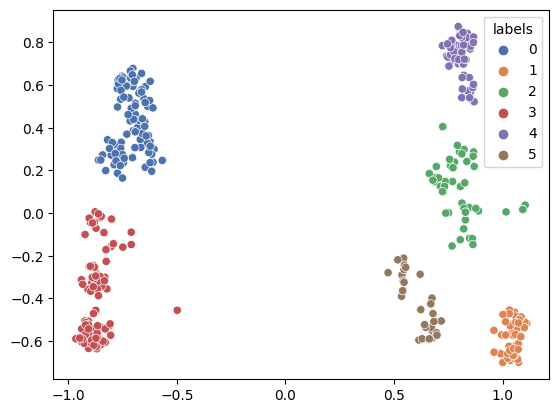

In [181]:
sns.scatterplot(x=X_onehot_pca[:,0], y=X_onehot_pca[:,1], hue=labels, palette="deep")

***
# Prediction

In [728]:
all_results = []

In [719]:
def create_folds(X,y,n_folds):
    folds = []
    cv_object = StratifiedKFold(n_splits = n_folds)
    for (train_indices, val_indices) in  cv_object.split(X_train, y_train):
        folds.append((train_indices,val_indices))
    return folds

In [775]:
from sklearn.model_selection import train_test_split, StratifiedKFold

# X = np.concatenate([pcs,dist], axis=1)
# X = pcs
# X = compatibility
# dataset = 'mds_compatibility'
X = X_dummies.join(villagers["n_appearances"]).to_numpy()
dataset = 'onehot_encoding'
y = villagers["tier"]

skf = StratifiedKFold()
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

In [791]:
from sklearn.feature_selection import SelectPercentile
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# classifier = KNeighborsClassifier()
# classifier = DecisionTreeClassifier()
# classifier = RandomForestClassifier()
# classifier = AdaBoostClassifier()
classifier = LogisticRegression(max_iter=10000)



param_grid = {
                #KNN
                # 'classifier__n_neighbors' : np.arange(1,30), 
                # 'classifier__weights' : ['uniform','distance']
                #TREE
                # 'classifier__criterion' : ["gini", "entropy"],
                # 'classifier__max_depth' : [None, 50, 100, 150, 200, 250, 300, 350, 400],
                # 'classifier__class_weight' : [None, "balanced"]
                #RANDOM FOREST
                # 'classifier__n_estimators' : np.arange(10,100,10),
                # 'classifier__criterion' : ["gini", "entropy"],
                # 'classifier__max_depth' : [None, 50, 100],
                #ADABOOST
                # 'classifier__n_estimators' : np.arange(10,100,10)
                #LOGISTIC
                'classifier__C' : np.logspace(-3,3,7)
            }


In [792]:
pipeline = Pipeline([
    ('classifier', classifier)])

n_folds = 5

folds = create_folds(X_train,y_train,n_folds)
assert isinstance(folds,list),'Folds must be presented as tuples of train and test index lists' 

# train model
cv = GridSearchCV(pipeline, param_grid, n_jobs=4, cv=folds, verbose=0, return_train_score=True, refit=True)
cv.fit(X_train, y_train)

GridSearchCV(cv=[(array([  3,   4,   5,   6,   7,   8,   9,  10,  11,  16,  17,  18,  19,
        20,  21,  22,  23,  24,  25,  26,  27,  28,  29,  30,  31,  37,
        38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,
        51,  52,  53,  54,  55,  65,  66,  67,  68,  69,  70,  71,  72,
        73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,  84,  85,
        86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,  98,
        99, 100, 101, 102, 103, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142...
       186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198,
       199, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316,
       317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329,
       330]))],
             estimator=Pipeline(steps=[('classifier',
                                        LogisticRegression(max_iter=10000))]),
             n_jobs=4,
             param_gr

In [793]:
results = cv.cv_results_
mean_train_score = results['mean_train_score'][cv.best_index_]
std_train_score = results['std_train_score'][cv.best_index_]
mean_cv_score = results['mean_test_score'][cv.best_index_]
std_cv_score = results['std_test_score'][cv.best_index_]

all_results.append([dataset, str(classifier), mean_cv_score, std_cv_score])

print('Training accuracy {} +/- {}'.format(mean_train_score, std_train_score))
print('Cross-validation accuracy: {} +/- {}'.format(mean_cv_score, std_cv_score))

print('Best estimator:')
print(cv.best_estimator_)

Training accuracy 0.6344511149228131 +/- 0.015115268898804926
Cross-validation accuracy: 0.4322478516508367 +/- 0.043174200982896725
Best estimator:
Pipeline(steps=[('classifier', LogisticRegression(max_iter=10000))])


In [800]:
model_results = pd.DataFrame(all_results, columns=["dataset", "classifier", "mean_cv_accuracy", "mean_cv_standard_deviation"])

In [829]:
model_results

,dataset,classifier,mean_cv_accuracy,mean_cv_standard_deviation
0,mds_compatibility,KNeighborsClassifier(),0.389914,0.037959
1,mds_compatibility,DecisionTreeClassifier(),0.296336,0.064843
2,mds_compatibility,RandomForestClassifier(),0.290276,0.057897
3,mds_compatibility,AdaBoostClassifier(),0.362777,0.076930
4,mds_compatibility,LogisticRegression(),0.395749,0.003618
5,onehot_encoding,KNeighborsClassifier(),0.422931,0.047569
6,onehot_encoding,DecisionTreeClassifier(),0.371777,0.046717
7,onehot_encoding,RandomForestClassifier(),0.420127,0.046762
8,onehot_encoding,AdaBoostClassifier(),0.395749,0.010243
9,onehot_encoding,LogisticRegression(),0.432248,0.043174


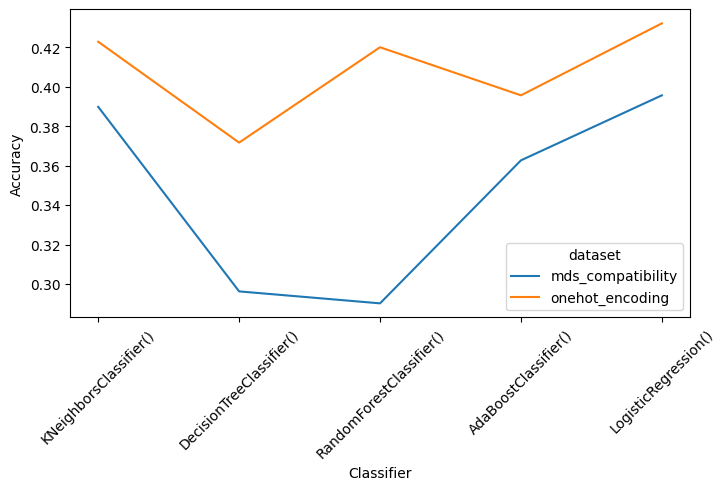

In [843]:
fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot()
sns.lineplot(ax=ax, data=model_results, x="classifier", y="mean_cv_accuracy", hue='dataset')

ax.set_ylabel('Accuracy', size=10)
ax.set_xlabel('Classifier', size=10)
ax.tick_params(axis='x', labelrotation=45)